# Assessing Neural Networks

This notebook demonstrates the use of a few tools for visualizing and assessing neural networks. In particular, this notebook will demonstrate the use of two tools for visualizing and assessing Keras neural networks:
* TensorBoard - web dashboard for monitoring progress of TensorFlow graphs (Keras can be hooked up to TensorBoard)

## Using a Baseline Keras Model

We'll start with a small, quick-to-train, poorly-performing Keras model, so that we can get straight to the mechanics of the tools.

To ease the assembly of models, and make them hot-swappable, we wrap model construction with objects in separate Python files. The models are named after American cities, and get progressively complex as the cities move east.

* Seattle - first pass, very basic CNN model, 50% accuracy

Future/planned models:

* Reno
* Phoenix
* Yellowstone
* Denver
* Omaha
* Kansas City
* Chicago
* Atlanta
* Richmond
* Washington
* Philly
* Manhattan
* Boston

In [1]:
%matplotlib inline

In [2]:
import numpy as np
np.random.seed(1337)
from scipy.misc import imresize 

# neural network constructor
from inyourface_seattle import seattle_model

# data constructor
from lfw_fuel import lfw

# utils
from keras.utils import np_utils
from keras import metrics
from keras.optimizers import SGD

# plots
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
# This is the simplest set of parameters,
# and leads to a so-so model.

BATCH_SIZE     = 128
NB_CLASSES     = 2
NB_EPOCH       = 12
N_FEATURE_MAPS = 32
FEATURE_WIDTH  = 32
FEATURE_HEIGHT = 32

In [4]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = lfw.load_data("deepfunneled")

In [5]:
# The cropImage function starts by cropping the image from 250x250 to 128x128
# It then scales the image to feature_width x feature_height
def cropImage(im, feature_width = FEATURE_WIDTH, feature_height = FEATURE_HEIGHT):
    im2 = np.dstack(im).astype(np.uint8)
    # return centered 128x128 from original 250x250 (40% of area)
    newim = im2[61:189, 61:189]
    sized1 = imresize(newim[:,:,0:3], (feature_width, feature_height), interp="bicubic", mode="RGB")
    sized2 = imresize(newim[:,:,3:6], (feature_width, feature_height), interp="bicubic", mode="RGB")
    return np.asarray([sized1[:,:,0], sized1[:,:,1], sized1[:,:,2], sized2[:,:,0], sized2[:,:,1], sized2[:,:,2]])

# Crop features
X_train = np.asarray(list(map(cropImage, X_train)))
X_test = np.asarray(list(map(cropImage, X_test)))

In [6]:
print(np.shape(X_train))
print(np.shape(X_test))

(2200, 6, 32, 32)
(1000, 6, 32, 32)


In [7]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, NB_CLASSES)
Y_test = np_utils.to_categorical(y_test, NB_CLASSES)

In [14]:
model = seattle_model( batch_size = BATCH_SIZE, 
                       nb_classes = NB_CLASSES,
                       nb_epoch = NB_EPOCH,
                       feature_maps = N_FEATURE_MAPS,
                       input_width = FEATURE_WIDTH,
                       input_height = FEATURE_HEIGHT
                     )

In [15]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 30, 30)        1760      
_________________________________________________________________
activation_3 (Activation)    (None, 32, 30, 30)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 28, 28)        9248      
_________________________________________________________________
activation_4 (Activation)    (None, 32, 28, 28)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 14, 14)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 14, 14)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
__________

In [16]:
# Optimization solver:
# Logarithmic loss function, plus stoachastic gradient descent
# Configure with a large momentum, large weight decay, small learning rate
LEARN_RATE = 0.1
MOMENTUM = 0.9
DECAY = LEARN_RATE/NB_EPOCH

sgd = SGD(lr=LEARN_RATE, 
          momentum=MOMENTUM, 
          decay=DECAY, 
          nesterov=False)

model.compile(loss='categorical_crossentropy', 
              optimizer=sgd, 
              metrics=[metrics.binary_accuracy, metrics.categorical_accuracy, metrics.mae])

## TensorBoard

In order to monitor and evaluate how well the neural network learning process is going, the TensorFlow library provides a tool called TensorBoard that will plot various quantities for the neural network versus time.

Start tensorboard like this:

```
$ tensorboard --logdir=logs/
```

then open the browser to `localhost:6006`.

In [17]:
from keras.callbacks import TensorBoard 
tb = TensorBoard(log_dir='./logs', write_graph=True, histogram_freq=0, write_images=True, embeddings_freq=0)

from keras.callbacks import Callback
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()

In [18]:
model.fit(X_train, Y_train, 
          batch_size = BATCH_SIZE, 
          epochs = NB_EPOCH, 
          verbose = 1, 
          validation_data = (X_test, Y_test),
          callbacks = [tb,history])

Train on 2200 samples, validate on 1000 samples
Epoch 1/12
2200/2200 [==============================] - 23s - loss: 0.6947 - binary_accuracy: 0.5095 - categorical_accuracy: 0.5105 - mean_absolute_error: 0.5002 - val_loss: 0.7059 - val_binary_accuracy: 0.5000 - val_categorical_accuracy: 0.5000 - val_mean_absolute_error: 0.4996
Epoch 2/12
2200/2200 [==============================] - 23s - loss: 0.6997 - binary_accuracy: 0.5086 - categorical_accuracy: 0.5086 - mean_absolute_error: 0.5001 - val_loss: 0.6983 - val_binary_accuracy: 0.5000 - val_categorical_accuracy: 0.5000 - val_mean_absolute_error: 0.4998
Epoch 3/12
2200/2200 [==============================] - 23s - loss: 0.6965 - binary_accuracy: 0.4818 - categorical_accuracy: 0.4818 - mean_absolute_error: 0.5008 - val_loss: 0.6941 - val_binary_accuracy: 0.5000 - val_categorical_accuracy: 0.5000 - val_mean_absolute_error: 0.4999
Epoch 4/12
2200/2200 [==============================] - 23s - loss: 0.6948 - binary_accuracy: 0.5009 - categoric

In [19]:
# lower-case y_test is not encoded, CAPITAL Y_test is encoded - use CAPITAL-Y_test!!
score = model.evaluate(X_test, Y_test, verbose=0)

print("-"*40)
print("Seattle Model (12 epochs):")
print('Test accuracy: {0:%}'.format(score[1]))

----------------------------------------
Seattle Model (12 epochs):
Test accuracy: 51.900000%


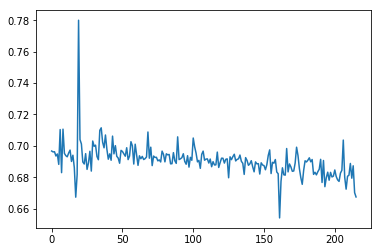

In [20]:
yy = history.losses
xx = range(len(yy))
plt.plot(xx,yy)

In [23]:
Y_pred = model.predict(X_test)

In [26]:
#print(len(Y_pred))
print(Y_pred[10:15])

[[ 0.48885226  0.51114774]
 [ 0.48388958  0.51611048]
 [ 0.49398416  0.50601584]
 [ 0.49398416  0.50601584]
 [ 0.49398416  0.50601584]]


In [28]:
#print(len(Y_test))
print(Y_test[10:15])

[[ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]]
